In [1]:
import sqlalchemy
from sqlalchemy import (create_engine, Column, String, Integer, Float, MetaData, 
                        Table, type_coerce, ForeignKey, case)
from sqlalchemy.orm import mapper, create_session, relationship, aliased, Session
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import case
import numpy as np
from sqlalchemy.ext.automap import automap_base
import matplotlib.pyplot as plt
import sqlalchemy.types as types
from sqlalchemy.sql import and_, or_, not_, func
from sqlalchemy.sql import select
import os
from os.path import isfile
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import datetime as dt
import glob
import gsw

%matplotlib inline

In [2]:
PATH= '/results/SalishSea/hindcast.201905/'
start_date = dt.datetime(2015,1,1)
end_date = dt.datetime(2015,12,31)
flen=1
namfmt='nowcast'
filemap={'nitrate':'ptrc_T','silicon':'ptrc_T','ammonium':'ptrc_T','diatoms':'ptrc_T','ciliates':'ptrc_T','flagellates':'ptrc_T','vosaline':'grid_T','votemper':'grid_T'}
fdict={'ptrc_T':1,'grid_T':1}

df1=et.loadDFO(datelims=(start_date,end_date))#,excludeSaanich=False)
df1.head()

,Year,Month,Day,Hour,Lat,Lon,Pressure,Depth,Ammonium,Ammonium_units,Chlorophyll_Extracted,Chlorophyll_Extracted_units,N,Si,Silicate_units,AbsSal,ConsT,Z,dtUTC
0,2015.0,2.0,11.0,11.068611,48.300833,-124.000333,1.9,None,None,None,NaN,mg/m^3,15.31,32.14,umol/L,29.227507,9.859421,1.884,2015-02-11 11:04:07
1,2015.0,2.0,11.0,11.068611,48.300833,-124.000333,6.6,None,None,None,2.57,mg/m^3,17.13,33.90,umol/L,29.484341,9.777243,6.54434,2015-02-11 11:04:07
2,2015.0,2.0,11.0,11.068611,48.300833,-124.000333,6.7,None,None,None,NaN,mg/m^3,NaN,NaN,umol/L,29.484839,9.771987,6.6435,2015-02-11 11:04:07
3,2015.0,2.0,11.0,11.068611,48.300833,-124.000333,11.0,None,None,None,NaN,mg/m^3,NaN,NaN,umol/L,30.144549,9.439995,10.9071,2015-02-11 11:04:07
4,2015.0,2.0,11.0,11.068611,48.300833,-124.000333,11.0,None,None,None,NaN,mg/m^3,20.62,37.65,umol/L,30.157913,9.433733,10.9071,2015-02-11 11:04:07


In [3]:
df2=df1.iloc[:50,:].copy(deep=True)

In [4]:
len(df2),len(df1)

(50, 569)

In [5]:
meshPath='/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc'
maskName='tmask'
with nc.Dataset(meshPath) as fmesh:
    omask=np.copy(fmesh.variables[maskName])
    navlon=np.copy(fmesh.variables['nav_lon'][:,:])
    navlat=np.copy(fmesh.variables['nav_lat'][:,:])

In [6]:
data=et._gridHoriz(df1,omask,navlon,navlat,wrapSearch=False)

In [7]:
data=data.sort_values(by=[ix for ix in ['dtUTC','Z','j','i']]) # preserve list order
data.reset_index(drop=True,inplace=True)

In [8]:
# set up columns to accept model values
for ivar in filemap.keys():
    data['mod_'+ivar]=np.full(len(data),np.nan)

In [9]:
ftypes=list(fdict.keys())
flist=dict()
for ift in ftypes:
    flist[ift]=et.index_model_files(start_date,end_date,'/results/SalishSea/hindcast.201905/',namfmt,flen,ift,fdict[ift])

In [10]:
filemap_r=dict()
for ift in ftypes:
    filemap_r[ift]=list()
for ikey in filemap:
    filemap_r[filemap[ikey]].append(ikey)

In [11]:
t0=dt.datetime.now()
data = et._binmatch(data,flist,ftypes,filemap_r,omask)
t1=dt.datetime.now()
print(t1-t0)

0:10:09.168010


In [12]:
import dask

In [13]:
def inc(x):
    return x + 1

def double(x):
    return x + 2

def add(x, y):
    return x + y

In [14]:
dataE = [1, 2, 3, 4, 5]

In [15]:
output = []
for x in dataE:
    a = dask.delayed(inc)(x)
    b = dask.delayed(double)(x)
    c = dask.delayed(add)(a, b)
    output.append(c)

total = dask.delayed(sum)(output)

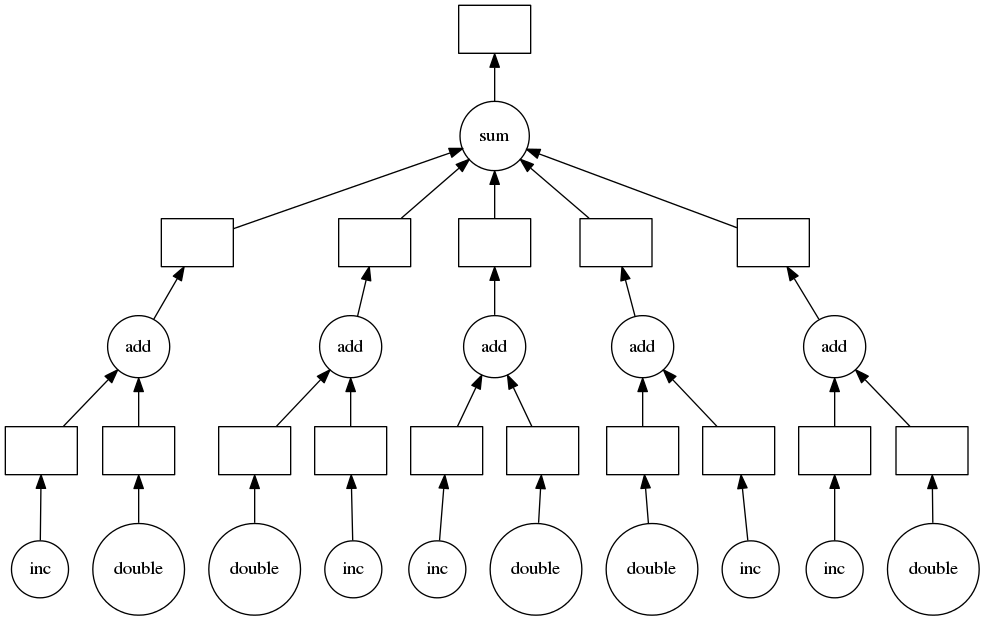

In [16]:
total.visualize() 

In [17]:
total.compute()

45

In [ ]:
nc.Dataset(frow['paths'].values[0])

'/results/SalishSea/hindcast.201905/01jan15/SalishSea_1h_20150101_20150101_ptrc_T.nc'

In [18]:
data['k']=-1*np.ones((len(data),)).astype(int)

In [29]:
with nc.Dataset(flist[ftypes[0]]['paths'][0]) as ift:
    for ind, row in data.iterrows():
        ik=et._getZInd_bin(row['Z'],ift)
        if (not np.isnan(ik)) and (omask[0,ik,row['j'],row['i']]==1):
            data.loc[ind,['k']]=int(ik)

In [30]:
t0=dt.datetime.now()
for ind, row in data.iterrows():
    if ind==0: # load first files
        fid=dict()
        fend=dict()
        for ift in ftypes:
            fid,fend=et._nextfile_bin(ift,row['dtUTC'],flist[ift],fid,fend,flist)
        torig=dt.datetime.strptime(fid[ftypes[0]].variables['time_centered'].time_origin,'%Y-%m-%d %H:%M:%S') # assumes same for all files in run
    for ift in ftypes:
        if row['dtUTC']>=fend[ift]:
            fid,fend=et._nextfile_bin(ift,row['dtUTC'],flist[ift],fid,fend,flist)
        ih=et._getTimeInd_bin(row['dtUTC'],fid[ift],torig)
        for ivar in filemap_r[ift]:
            data.loc[ind,['mod_'+ivar]]=fid[ift].variables[ivar][ih,row['k'],row['j'],row['i']]
t1=dt.datetime.now()
print(t1-t0)

0:00:44.921380


In [36]:
ftypes

['ptrc_T', 'grid_T']

In [ ]:
def nextfile2():
    #def _nextfile_bin(ift,idt,ifind,fid,fend,flist):
    frow=ifind.loc[(ifind.t_0<=idt)&(ifind.t_n>idt)]
    fid[ift]=nc.Dataset(frow['paths'].values[0])
    fend[ift]=frow['t_n'].values[0]
    #return fid, fend
    return findex

In [30]:
flistUse=dict()
for ift in ftypes:
    flistUse[ift]=dict()
for ind, row in data.iterrows():
    if ind==0: # load first files
        fid=dict()
        fend=dict()
        for ift in ftypes:
            fid,fend=et._nextfile_bin(ift,row['dtUTC'],flist[ift],fid,fend,flist)
        torig=dt.datetime.strptime(fid[ftypes[0]].variables['time_centered'].time_origin,'%Y-%m-%d %H:%M:%S') # assumes same for all files in run
    for ift in ftypes:
        if row['dtUTC']>=fend[ift]:
            fid,fend=et._nextfile_bin(ift,row['dtUTC'],flist[ift],fid,fend,flist)
        ih=et._getTimeInd_bin(row['dtUTC'],fid[ift],torig)
        for ivar in filemap_r[ift]:
            data.loc[ind,['mod_'+ivar]]=fid[ift].variables[ivar][ih,row['k'],row['j'],row['i']]


0:00:44.921380


In [39]:
# ftypes: ptrc_T, grid_T
# flistUse
#    ptrc_T
#       list of files to actually open
#           map each file to an index to data and 
#    grid_T

['ptrc_T', 'grid_T']

In [ ]:
# just index, don't open:
for ind, row in data.iterrows():
    if ind==0: # load first files
        fid=dict()
        fend=dict()
        for ift in ftypes:
            fid,fend=et._nextfile_bin(ift,row['dtUTC'],flist[ift],fid,fend,flist)
        torig=dt.datetime.strptime(fid[ftypes[0]].variables['time_centered'].time_origin,'%Y-%m-%d %H:%M:%S') # assumes same for all files in run
    for ift in ftypes:
        if row['dtUTC']>=fend[ift]:
            fid,fend=et._nextfile_bin(ift,row['dtUTC'],flist[ift],fid,fend,flist)
        ih=et._getTimeInd_bin(row['dtUTC'],fid[ift],torig)
        for ivar in filemap_r[ift]:
            data.loc[ind,['mod_'+ivar]]=fid[ift].variables[ivar][ih,row['k'],row['j'],row['i']]

In [38]:
fend

{'ptrc_T': datetime.datetime(2015, 4, 3, 0, 0),
 'grid_T': datetime.datetime(2015, 4, 3, 0, 0)}

In [31]:
import xarray as xr

In [37]:
t0=dt.datetime.now()
test=xr.open_mfdataset(flist[ftypes[0]]['paths'],parallel=True)
t1=dt.datetime.now()
print(t1-t0)

0:02:09.459820


In [ ]:
t0=dt.datetime.now()
test=xr.open_mfdataset(flist[ftypes[0]]['paths'])
t1=dt.datetime.now()
print(t1-t0)

In [33]:
test

<xarray.Dataset>
Dimensions:                       (axis_nbounds: 2, deptht: 40, nvertex: 4, time_counter: 8760, x: 398, y: 898)
Coordinates:
    nav_lat                       (y, x) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    nav_lon                       (y, x) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
  * deptht                        (deptht) float32 0.5000003 ... 441.4661
    time_centered                 (time_counter) datetime64[ns] dask.array<shape=(8760,), chunksize=(24,)>
  * time_counter                  (time_counter) datetime64[ns] 2015-01-01T00:30:00 ... 2015-12-31T23:30:00
Dimensions without coordinates: axis_nbounds, nvertex, x, y
Data variables:
    bounds_lon                    (time_counter, y, x, nvertex) float32 dask.array<shape=(8760, 898, 398, 4), chunksize=(24, 898, 398, 4)>
    bounds_lat                    (time_counter, y, x, nvertex) float32 dask.array<shape=(8760, 898, 398, 4), chunksize=(24, 898, 398, 4)>
    area                          (time_counter, y, x